In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import time
import sklearn

import sys, os
# This is not super pretty, but I think this is the best way to import stuff from ../../../util?
CODE_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if CODE_ROOT not in sys.path:
    sys.path.insert(1, CODE_ROOT)

from util.spectra_helpers import SpectraCustomHDF5
from util.sim_data_helpers import get_cosmo_parameters

random_seed_number = 123

In [3]:
def build_dataset_for_gridpoints(gridpoints, suite_to_use, suite_of_spectra):
    """Collects the Flux data from the gridpoint spectra files and returns them as X and y data np.arrays

    Args:
        gridpoints (list): list with the grid point numbers to use
        suite_to_use (string): simulation suite to use

    Returns:
        np.array(X): Array of spectra (flux values)
        np.array(y): Array of cosmo parameters (for each spectrum)
    """
    X, y = [], []

    for i in gridpoints:
        path_to_file = f"/vera/ptmp/gc/jerbo/training_data/{suite_of_spectra}/gp{i}_spectra.hdf5"
        spec_file = SpectraCustomHDF5(path_to_file)
        _, flux = spec_file.get_all_spectra()  
        flux = flux[:1000]  # (1000, 468) TODO: delete this line for training with the full dataset

        params = get_cosmo_parameters(
            f"/vera/ptmp/gc/jerbo/{suite_to_use}/gridpoint{i}/"
        )

        for spec in flux:
            X.append(spec)
            y.append(params)

    return np.array(X), np.array(y)


class SpectraCosmoDataset(Dataset):
    """Class that defines a custom dataset for the spectra data
    """
    def __init__(self, X, y, dtype=torch.float32):
        self.X = torch.tensor(X, dtype=dtype)
        self.y = torch.tensor(y, dtype=dtype)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    

def _normalize(dataset, X_mean, X_std, y_mean, y_std):
    """Normalize the given dataset using the other given parameters

    Args:
        dataset (torch.utils.data.Dataset): dataset to be normalized
        X_mean (float): mean of the training X data
        X_std (_type_): std of the training X data
        y_mean (_type_): mean of the training y data
        y_std (_type_): std of the training y data
    """
    # dataset.X = (dataset.X - X_mean) / X_std
    dataset.y = (dataset.y - y_mean) / y_std


def get_datasets(suite_to_use, suite_of_spectra):
    """Split the gridpoints into training, test and eval and then collect the datasets and normalize them

    Args:
        suite_to_use (string): simulation suite to use
        log_file_path (string): path to the log file

    Returns:
        train_dataset (SpectraCosmoDataset): training dataset
        test_dataset (SpectraCosmoDataset): test dataset
        eval_dataset (SpectraCosmoDataset): evaluation dataset
    """

    ################# Make random list of gridpoints for train, eval and test sets #################
    index_list = np.array(list(range(50)))
    np.random.seed(123)
    np.random.shuffle(index_list)

    n_train = int(0.7 * len(index_list))
    n_eval  = int(0.15 * len(index_list))

    train_gps = index_list[:n_train]
    eval_gps  = index_list[n_train:n_train + n_eval]
    test_gps  = index_list[n_train + n_eval:]

    ################ Make the datasets #####################

    X_train, y_train = build_dataset_for_gridpoints(train_gps, suite_to_use, suite_of_spectra)
    X_eval,  y_eval  = build_dataset_for_gridpoints(eval_gps,  suite_to_use, suite_of_spectra)
    X_test,  y_test  = build_dataset_for_gridpoints(test_gps,  suite_to_use, suite_of_spectra)

    train_dataset = SpectraCosmoDataset(X_train, y_train)
    eval_dataset  = SpectraCosmoDataset(X_eval,  y_eval)
    test_dataset  = SpectraCosmoDataset(X_test,  y_test)

    ############### Standardize the data ####################

    X_mean = train_dataset.X.mean(dim=0)
    X_std  = train_dataset.X.std(dim=0) + 1e-8

    y_mean = train_dataset.y.mean(dim=0)
    y_std  = train_dataset.y.std(dim=0) + 1e-8

    _normalize(train_dataset, X_mean, X_std, y_mean, y_std)
    _normalize(eval_dataset, X_mean, X_std, y_mean, y_std)
    _normalize(test_dataset, X_mean, X_std, y_mean, y_std)

    ############## Test if there is no information leakege between datasets ##############

    train_cosmo = set(map(tuple, y_train))
    test_cosmo  = set(map(tuple, y_test))

    assert train_cosmo.isdisjoint(test_cosmo)

    return train_dataset, test_dataset, eval_dataset, y_std, y_mean


def get_datasets_shuffle_over_gps(suite_to_use, suite_of_spectra, log_file_path):
    """ This function is for debugging purposes only
    """
    gps_list = [i for i in range(50)]

    X_all, y_all = build_dataset_for_gridpoints(gps_list, suite_to_use, suite_of_spectra)

    print(X_all.shape[0])

    index_list = np.array(list(range(X_all.shape[0])))
    np.random.seed(42)
    np.random.shuffle(index_list)

    X_all = X_all[index_list]
    y_all = y_all[index_list]

    n_train = int(0.7 * X_all.shape[0])
    n_eval  = int(0.15 * X_all.shape[0])

    print(n_train, n_eval)

    X_train, y_train = X_all[:n_train], y_all[:n_train]
    X_eval,  y_eval = X_all[n_train:n_eval+n_train], y_all[n_train:n_eval+n_train]
    X_test,  y_test = X_all[n_eval+n_train:], y_all[n_eval+n_train:]

    train_dataset = SpectraCosmoDataset(X_train, y_train)
    eval_dataset  = SpectraCosmoDataset(X_eval,  y_eval)
    test_dataset  = SpectraCosmoDataset(X_test,  y_test)

    X_mean = train_dataset.X.mean(dim=0)
    X_std  = train_dataset.X.std(dim=0) + 1e-8

    y_mean = train_dataset.y.mean(dim=0)
    y_std  = train_dataset.y.std(dim=0) + 1e-8

    _normalize(train_dataset, X_mean, X_std, y_mean, y_std)
    _normalize(eval_dataset, X_mean, X_std, y_mean, y_std)
    _normalize(test_dataset, X_mean, X_std, y_mean, y_std)

    return train_dataset, eval_dataset, test_dataset

In [4]:
suite_to_use = "L25n256_suite"
suite_of_spectra = "L25n256_suite_no_noise"
batch_size = 64

# get the datasets
train_dataset, eval_dataset, test_dataset, y_std, y_mean = get_datasets(suite_to_use, suite_of_spectra)

# make the dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# get input and output size
len_spectra = train_dataset.X.shape[1]
len_output = train_dataset.y.shape[1]

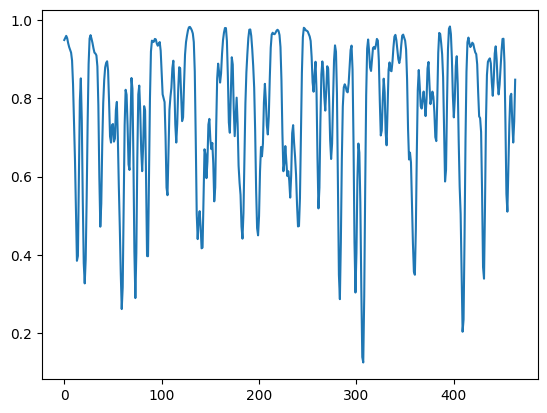

In [5]:
plt.plot([i for i in range(len_spectra)], train_dataset.X[1])
plt.show()

In [14]:
torch.manual_seed(random_seed_number)
# create the neural network
net = torch.nn.Sequential(
    torch.nn.Linear(len_spectra, 300),
    torch.nn.ReLU(),
    torch.nn.Linear(300, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, len_output))
# set lossfunction
loss_fn = torch.nn.MSELoss()
# set optimizer and learningrate
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

print("Number of network parameters:", np.sum([np.prod(theta.shape) for theta in net.parameters()]))

Number of network parameters: 170004


In [15]:
import tqdm

100%|██████████| 547/547 [01:24<00:00,  6.51it/s]


Completed epoch  0 in 87.0s, Train loss=5.1e-01, Test loss=1.5e+00


100%|██████████| 547/547 [01:24<00:00,  6.50it/s]


Completed epoch  5 in 435.5s, Train loss=4.1e-01, Test loss=1.8e+00


100%|██████████| 547/547 [01:24<00:00,  6.50it/s]


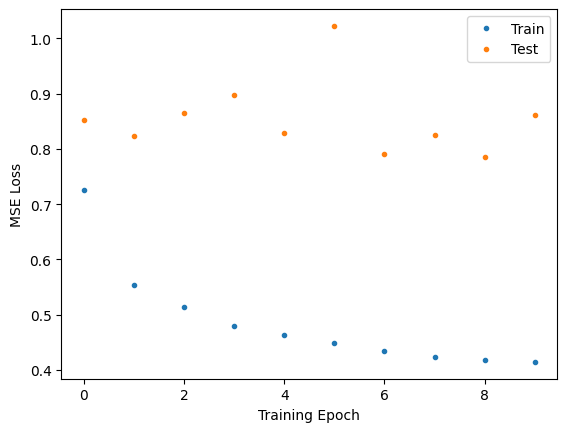

In [16]:
losses = []
losses_test = []
eta = 10
start_time = time.time()
for epoch in range(eta):
    net.train()
    tmp = []
    for x_batch, y_batch in tqdm.tqdm(train_loader):
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        tmp.append(loss.data)
    losses.append(np.array(tmp).mean())
    
    net.eval() 
    with torch.no_grad():
        tmp = []
        for x_batch, y_batch in eval_loader:
            y_pred = net(x_batch)
            test_loss = loss_fn(y_pred, y_batch)
            tmp.append(test_loss.data)
        losses_test.append(np.array(tmp).mean())

    if epoch % (eta/4) == 0:
        end_time=time.time()
        elapsed_time = end_time - start_time
        print("Completed epoch %2d in %4.1fs, Train loss=%4.1e, Test loss=%4.1e" % (epoch, elapsed_time, loss.data, test_loss.data))
        start_time = time.time()
        
plt.plot(losses, '.', label="Train")
plt.plot(losses_test, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('MSE Loss')
# plt.yscale('log')
plt.show()

In [37]:
def eval_model(model, loader, criterion):
    all_preds = []
    all_targets = []
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for X, y in loader:
            y_pred = model(X)
            loss = criterion(y_pred, y)

            total_loss += loss.item() * X.size(0)

            all_preds.append(y_pred)
            all_targets.append(y)

        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)
    
    avarage_loss = total_loss / len(loader.dataset)
    return avarage_loss, all_targets, all_preds

In [38]:
test_loss, y_test_true, y_test_pred = eval_model(net, test_loader, loss_fn)

print(f"Test MSE: {test_loss:.4e}")

Test MSE: 7.7981e-01


In [39]:
# undo the normalization
y_test_true, y_test_pred  = y_test_true*y_std + y_mean, y_test_pred*y_std + y_mean
y_true, y_pred = y_test_true.numpy(), y_test_pred.numpy()

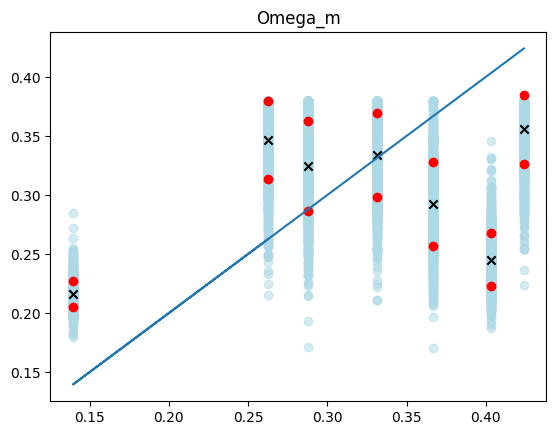

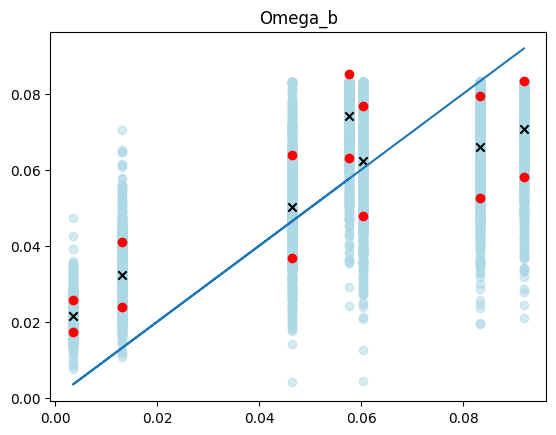

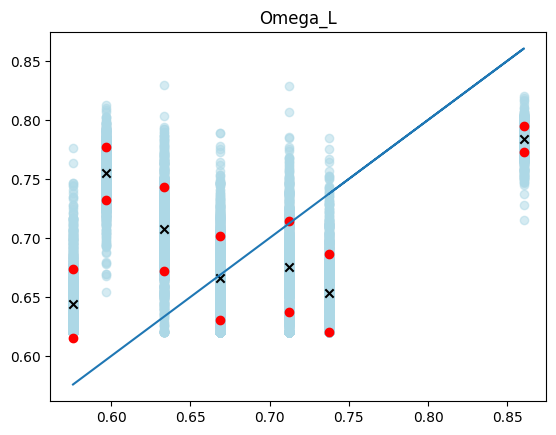

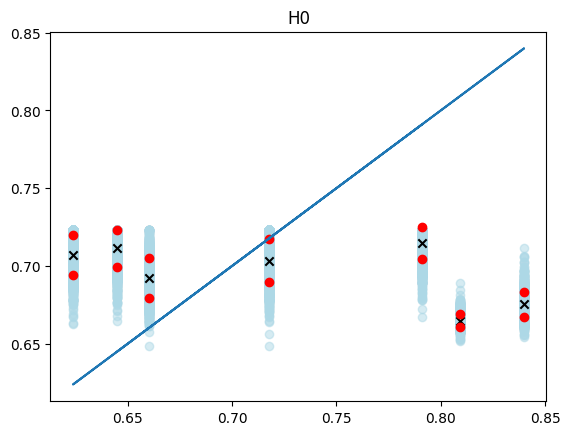

In [40]:
params = ["Omega_m", "Omega_b", "Omega_L", "H0"]

y_true_by_param = [y_true[:, i] for i in range(len(params))]
y_pred_by_param = [y_pred[:, i] for i in range(len(params))]

for index in range(4):

    y_true_Om = y_true_by_param[index]
    y_pred_Om = y_pred_by_param[index]

    y_pred_mean_Om = []
    y_pred_std_Om = []
    y_true_unique_Om = []
    y_pred_per_unique_value = []
    for true_value in set(y_true_Om):
        y_pred_this_true_value = y_pred_Om[y_true_Om == true_value]
        mean_this_true_value = y_pred_this_true_value.mean()
        std_this_true_value = y_pred_this_true_value.std()
        min_this_true_value = y_pred_this_true_value.min()
        max_this_true_value = y_pred_this_true_value.max()

        y_pred_std_Om.append(std_this_true_value)
        y_pred_mean_Om.append(mean_this_true_value)
        y_true_unique_Om.append(true_value)

        y_pred_per_unique_value.append(y_pred_this_true_value)

    plt.scatter(y_true_Om, y_pred_Om, alpha=0.5, c="lightblue")
    plt.scatter(y_true_unique_Om, y_pred_mean_Om, linestyle="None", marker="x", color="black")
    plt.scatter(y_true_unique_Om, [y_pred_mean_Om[i]+y_pred_std_Om[i] for i in range(len(y_true_unique_Om))], linestyle="None", marker="o", color="red")
    plt.scatter(y_true_unique_Om, [y_pred_mean_Om[i]-y_pred_std_Om[i] for i in range(len(y_true_unique_Om))], linestyle="None", marker="o", color="red")
    plt.plot(y_true_Om, y_true_Om)
    plt.title(f"{params[index]}")
    plt.show()
